In [2]:
import numpy as np
import healpy as hp
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy import stats
import random


NSIDE = 32   # this is about 1.8 deg between bins... https://lambda.gsfc.nasa.gov/toolbox/tb_pixelcoords.cfm
n_dec_bins = 33

# define some helper functions
#convert healpy "theta" to dec
def theta_to_dec(theta):
    # shift dec from 0-180 to (90, -90)   (note -1.0*(theta-90) to get North pole at 0 "theta" for healpy)
    return -1.0*(theta - np.pi/2.0)

#find out which bin an event is in based on "the_bins" boundaries
def which_dec_bin(dec, the_bins):
        for i in range(0, len(the_bins)-1):
            if the_bins[i] <= dec < the_bins[i+1]:
                return i
            
## My Favorite source TXS 0506+056
txs_ra = 77.3582
txs_dec = 5.69314
txs_bin = hp.ang2pix(NSIDE, theta_to_dec(np.radians(txs_dec)), np.radians(txs_ra))
print("Favorite spot at TXS 0506+056 ", txs_dec, txs_ra, txs_bin)

Favorite spot at TXS 0506+056  5.69314 77.3582 5595


In [4]:
# let's load up the data
np_dtype = np.float64
data_7 = np.genfromtxt('./data/events/IC86_VII_exp.csv', names=True, dtype=np_dtype)
data_6 = np.genfromtxt('./data/events/IC86_VI_exp.csv', names=True, dtype=np_dtype)
data_5 = np.genfromtxt('./data/events/IC86_V_exp.csv', names=True, dtype=np_dtype)
data_4 = np.genfromtxt('./data/events/IC86_IV_exp.csv', names=True, dtype=np_dtype)
data_3 = np.genfromtxt('./data/events/IC86_III_exp.csv', names=True, dtype=np_dtype)
data_2 = np.genfromtxt('./data/events/IC86_II_exp.csv', names=True, dtype=np_dtype)
data_1 = np.genfromtxt('./data/events/IC86_I_exp.csv', names=True, dtype=np_dtype)
## Concantenate these together into 1
data_7y = np.concatenate((data_7, data_6, data_5, data_4, data_3, data_2, data_1))
#data_7y = np.concatenate((data_7, data_6))

In [5]:
## Ensure that everything got put together correctly...
print(len(data_7y))
#print(len(data_1)+len(data_2)+len(data_3)+len(data_4)+len(data_5)+len(data_6)+len(data_7))
data_7y

897406


array([(57891.17694387, 2.9 , 0.89, 343.245,  13.768,  46.287, 103.86 ),
       (57891.18095108, 3.13, 0.35, 127.003,  35.576, 263.912, 125.521),
       (57891.18877491, 4.7 , 0.2 , 216.473, -23.266, 177.292,  66.652),
       ...,
       (56062.4089819 , 2.79, 3.03, 240.151,  51.702, 230.512, 141.666),
       (56062.41103019, 3.42, 0.74, 245.893,  37.043, 225.485, 127.012),
       (56062.41621633, 2.84, 0.2 , 346.941,  67.104, 126.317, 157.163)],
      dtype=[('MJDdays', '<f8'), ('log10EGeV', '<f8'), ('AngErrdeg', '<f8'), ('RAdeg', '<f8'), ('Decdeg', '<f8'), ('Azimuthdeg', '<f8'), ('Zenithdeg', '<f8')])

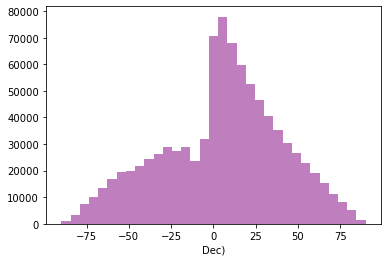

[ 1030.  3421.  7429. 10190. 13586. 16928. 19400. 19802. 21855. 24219.
 26374. 28862. 27409. 28711. 23680. 31977. 70692. 77905. 68150. 59833.
 52777. 46490. 40420. 35174. 30539. 26661. 23030. 19289. 15377. 11223.
  8156.  5276.  1541.] [-89.957      -84.50445455 -79.05190909 -73.59936364 -68.14681818
 -62.69427273 -57.24172727 -51.78918182 -46.33663636 -40.88409091
 -35.43154545 -29.979      -24.52645455 -19.07390909 -13.62136364
  -8.16881818  -2.71627273   2.73627273   8.18881818  13.64136364
  19.09390909  24.54645455  29.999       35.45154545  40.90409091
  46.35663636  51.80918182  57.26172727  62.71427273  68.16681818
  73.61936364  79.07190909  84.52445455  89.977     ]


In [6]:
#let's bin the data into n_dec_bins using the hist function from pyply package
# plt.hist returns 2 objects we need:  list of counts in each bin (n_dec_bins, and list of bin boundaries (n_dec_bins +1)
decbin_content,decbin_boundaries,extra = plt.hist(data_7y['Decdeg'], n_dec_bins, facecolor='purple', alpha=0.5)
plt.xlabel('Dec)')
plt.show()
print(decbin_content,decbin_boundaries)

In [7]:
#Let's calculate the number of PIXELS in each dec band using the position of each
# generate a list of pixel
dec_vals = []
for bin in range(0,hp.nside2npix(NSIDE)):
    theta,phi = hp.pix2ang(NSIDE,bin)
    dec_vals.append(np.degrees(theta_to_dec(theta)))

dec_vals2 = np.array(dec_vals)

# use numpy's digitize function to "count in bins" -> returns an array telling you which bin each value is in
hp_bins_mask = np.digitize(dec_vals2, decbin_boundaries)

# count number of bins at each bin mask value:  total in that dec range
hp_bins_perdec = [len(dec_vals2[hp_bins_mask == i]) for i in range(1, len(decbin_boundaries))]

print(len(hp_bins_perdec),hp_bins_perdec,sum(hp_bins_perdec))

33 [24, 88, 152, 156, 264, 328, 288, 440, 372, 512, 512, 512, 512, 512, 640, 512, 640, 512, 640, 512, 512, 512, 512, 512, 372, 440, 288, 328, 264, 156, 152, 88, 24] 12288


In [8]:
# now let's calculate the averge background per-pixel in each dec band
avg_bkg_perbin = decbin_content/hp_bins_perdec
print(avg_bkg_perbin)

[ 42.91666667  38.875       48.875       65.32051282  51.46212121
  51.6097561   67.36111111  45.00454545  58.75        47.30273438
  51.51171875  56.37109375  53.53320312  56.07617188  37.
  62.45507812 110.45625    152.15820312 106.484375   116.86132812
 103.08007812  90.80078125  78.9453125   68.69921875  82.09408602
  60.59318182  79.96527778  58.80792683  58.24621212  71.94230769
  53.65789474  59.95454545  64.20833333]


Using  12288  pixels


/opt/conda/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/opt/conda/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/opt/conda/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To 

Plotted points:  895288


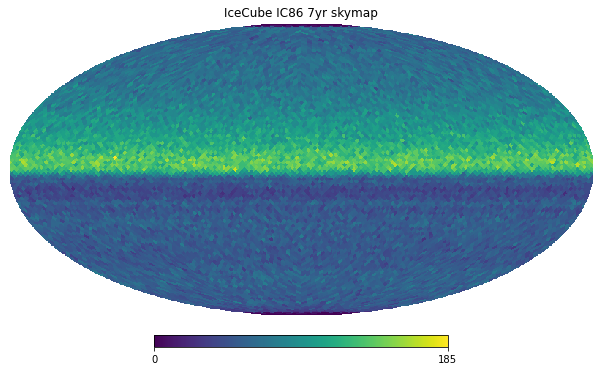

In [9]:
# Let's bin the data in a skymap healpix object
## The standard coordinates are the colatitude $\theta$, $0$ at the North Pole, $\pi/2$ at the equator and $\pi$ at the South Pole 
## and the longitude $\phi$ between $0$ and $2\pi$ eastward, in a Mollview projection, $\phi=0$ is at the center and increases eastward toward the left of the map.
print('Using ',hp.nside2npix(NSIDE), ' pixels')
## seed skymap with 0 counts in each bin
skymap = np.zeros(hp.nside2npix(NSIDE))
n_plot = 0
for ev in data_7y:
    if np.abs(ev["Decdeg"]) < 85.0:   # must avoid poles for later analysis/scrambling
        # shift dec to 0-180 instead of 90, -90   (note -1.0* (dec-90) to get North pole at 0 "theta" for healpy)
        #binnum = hp.ang2pix(NSIDE, -1.0*(np.radians(ev["Decdeg"])-np.pi/2.0), np.radians(ev["RAdeg"]))
        binnum = hp.ang2pix(NSIDE, theta_to_dec(np.radians(ev["Decdeg"])), np.radians(ev["RAdeg"]))
        skymap[binnum] += 1
        n_plot += 1
##  Highlight your test bin (to test)
## skymap[txs_bin] = 1000
hp.mollview(skymap, title="IceCube IC86 7yr skymap")
print('Plotted points: ', n_plot)

Plotted points:  895288  Max bin: 6094 61.54375


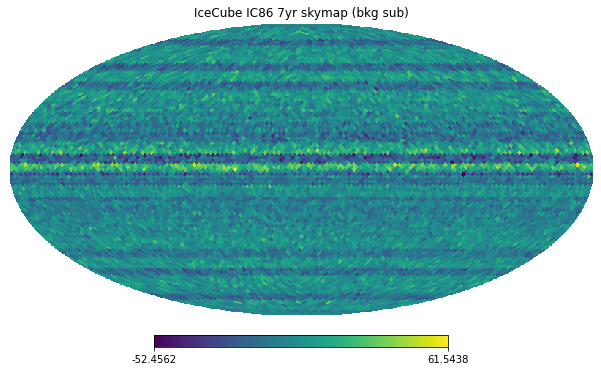

In [10]:
# Calculate the difference between observed and expected counts, as well as the poisson pmf (assuming expected bkg is average expected rate)
#then plot the difference skymap
skymap2 = []
p_val_map =[]
for bin in range(0,hp.nside2npix(NSIDE)):
    theta,phi = hp.pix2ang(NSIDE,bin)
    bkg_bin = which_dec_bin(np.degrees(theta_to_dec(theta)),decbin_boundaries)
    if np.abs(np.degrees(theta_to_dec(theta))) < 85.0:
        this_bin_excess = skymap[bin] - avg_bkg_perbin[bkg_bin]
        skymap2.append(this_bin_excess)
        if (this_bin_excess > 0.0 ):  # don't highlight underfluctionations
            p_val_map.append(stats.poisson.pmf(skymap[bin], avg_bkg_perbin[bkg_bin]))
        else:
            p_val_map.append(1.0)
    else:
        skymap2.append(0.0)
        p_val_map.append(1.0)

skymap2_np  = np.array(skymap2)
hp.mollview(skymap2_np, title="IceCube IC86 7yr skymap (bkg sub)")
print('Plotted points: ', n_plot, ' Max bin:',np.argmax(skymap2_np), np.max(skymap2_np))

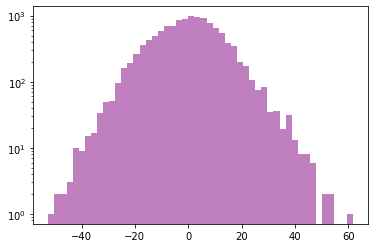

In [11]:
# plot the histogram of the 'counts - expected' values in the map
a,b,c = plt.hist(skymap2_np, 50, facecolor='purple', alpha=0.5,log=True)
# is it centered near zero?  Does it look somewhat gaussian

7.871115713300378 6094
1.5707963267948966 0.7117670855789374
Most significant spot: log_10(pvalue): 7.871115713300378  at DEC, RA:  -0.0 40.78124999999999
Observing n_events excess:  61.54375 background:  110.45625 counts:  172.0
TXS p-val:  -0.0


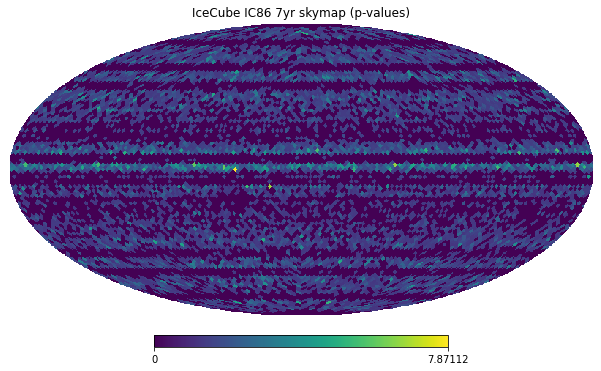

In [14]:
# plot the skymap of poission p-values (-log10(pvalue))

p_val_map_np  = -1.0*np.log10(np.array(p_val_map))
hp.mollview(p_val_map_np, title="IceCube IC86 7yr skymap (p-values)")

# Find the most interesting spot:
max_pval = np.max(p_val_map_np)
max_bin  = np.argmax(p_val_map_np)
print(max_pval, max_bin)
theta_max ,phi_max = hp.pix2ang(NSIDE,max_bin)
print(theta_max,phi_max)
bkg_bin_max = which_dec_bin(np.degrees(theta_to_dec(theta_max)),decbin_boundaries)

print('Most significant spot: log_10(pvalue):', max_pval, ' at DEC, RA: ', np.degrees(theta_to_dec(theta_max)), np.degrees(phi_max))
print('Observing n_events excess: ', skymap2[max_bin], 'background: ', avg_bkg_perbin[bkg_bin_max], 'counts: ', skymap[max_bin])

print('TXS p-val: ', p_val_map_np[txs_bin])

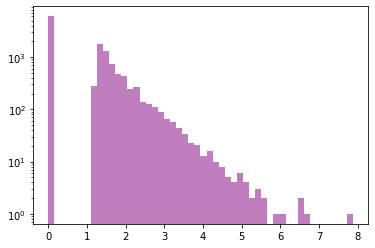

In [15]:
# plot the histogram of the p-values in the map
a,b,c = plt.hist(p_val_map_np, 50, facecolor='purple', alpha=0.5,log=True)
# is it centered near zero?  Does it look somewhat gaussian

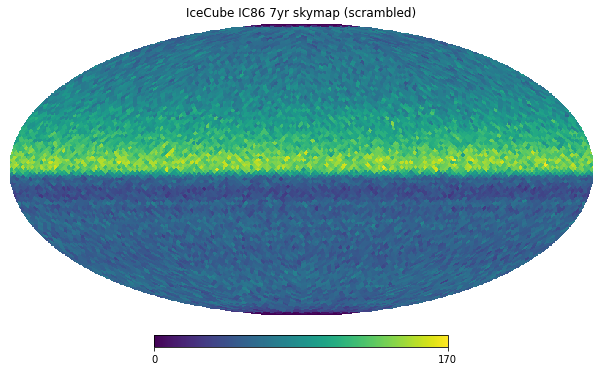

In [16]:
# let's think about scrambling...
def do_a_scramble(events):
    skymap_scr = np.zeros(hp.nside2npix(NSIDE))
    random.seed()
    for ev in events:
        if np.abs(ev["Decdeg"]) < 85.0:   # must avoid poles for later analysis/scrambling
            # generate a new random RA value (2 options, pick another RA, or pick from 0,2pi uniformly)
            new_ra = random.uniform(0,2.0*np.pi)
            #binnum = hp.ang2pix(NSIDE, -1.0*(np.radians(ev["Decdeg"])-np.pi/2.0), new_ra)
            binnum = hp.ang2pix(NSIDE, theta_to_dec(np.radians(ev["Decdeg"])), new_ra)
            skymap_scr[binnum] += 1
    return skymap_scr

new_skymap = do_a_scramble(data_7y)
hp.mollview(new_skymap, title="IceCube IC86 7yr skymap (scrambled)")

In [18]:
# let's do many scrambles  For each scrable, calculate the most significant point and which bin that's in.
def do_n_scrambles(events, n_scrambles = 3):
    max_p_values_scr = []
    max_p_bin_scr = []
    txs_p_values_scr = []
    for trial in range(0,n_scrambles):
        print(trial, end = ' ')
        this_map = do_a_scramble(events)
        this_p_val_map = []
        for bin in range(0,hp.nside2npix(NSIDE)):
            theta,phi = hp.pix2ang(NSIDE,bin)
            bkg_bin = which_dec_bin(np.degrees(theta_to_dec(theta)),decbin_boundaries)
            if np.abs(np.degrees(theta_to_dec(theta))) < 85.0:
                if (this_map[bin] > avg_bkg_perbin[bkg_bin]):  # only look at positive excesses
                    this_p_val_map.append(stats.poisson.pmf(this_map[bin], avg_bkg_perbin[bkg_bin]))
                else:
                    this_p_val_map.append(1.0)
            else:
                this_p_val_map.append(1.0)
        this_p_val_map_np = -1.0*np.log10(np.array(this_p_val_map))
        max_p_values_scr.append(np.max(this_p_val_map_np))
        max_p_bin_scr.append(np.argmax(this_p_val_map_np))
        txs_p_values_scr.append(this_p_val_map_np[txs_bin])
    return max_p_values_scr, max_p_bin_scr, txs_p_values_scr

# test it!
p_vals_max_scr, bin_max_scr, txs_p_vals_scr = do_n_scrambles(data_7y,n_scrambles = 3) 

0 

KeyboardInterrupt: 

In [ ]:
print(p_vals_max_scr, bin_max_scr)
print(txs_p_vals_scr)
# compare where in the distribution of these scrambled max_p_values the real data is at?  Is it rare or common?

In [ ]:
a,b,c = plt.hist(p_vals_max_scr, 10, facecolor='purple', alpha=0.5)

test = np.array(p_vals_max_scr)
print('estimated all sky trials corrected p-value: ',len(test[test>max_pval])/len(test))
print('Recall max p-value - ',max_pval)


In [ ]:
a,b,c = plt.hist(txs_p_vals_scr, 20, facecolor='purple', alpha=0.5,log=True)


test2 = np.array(txs_p_vals_scr)
len(test2[test2>p_val_map_np[txs_bin]])/len(test2)
print('estimated txs trials corrected p-value:', len(test2[test2>p_val_map_np[txs_bin]])/len(test2))
print('Recall max p-value - ', p_val_map_np[txs_bin] )

Items below here are older, for reference...

In [ ]:
coszen = np.cos(np.radians(data_7y['Zenithdeg']))
plt.hist(coszen, 20, facecolor='purple', alpha=0.5)
plt.xlabel('Cos(Zenith)')
plt.show()

In [ ]:
plt.hist(data_7y['AngErrdeg'], 50, facecolor='red', alpha=0.5,log=True)
plt.xlabel('Angular Error(deg)')
plt.show()

In [ ]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

sindec = np.sin(np.radians(data_7y['Decdeg']))
plt.hist(sindec, 50, facecolor='purple', alpha=0.5)
plt.xlabel('Sin(Dec)')
plt.show()

In [ ]:
plt.hist(data_7y['Azimuthdeg'], 50, facecolor='red', alpha=0.5)
plt.xlabel('Azimuth(deg)')
plt.show()

In [ ]:
masktf = [data_7y['log10EGeV']<4.0]

reduced_azi = data_7y['Azimuthdeg'][data_7y['log10EGeV']<4.0]
print(masktf, len(masktf), len(data_7y), len(reduced_azi))


#reduce_azi = [data_7y['Azimuthdeg'](data_7y['log10EGeV']>4.0)]
plt.hist(reduced_azi, 50, facecolor='red', alpha=0.5)
plt.xlabel('Azimuth(deg)')
plt.show()

In [ ]:
## Calculate the exposure in time of this sample using the 'uptime' data
exposure_7 = np.genfromtxt('../data/uptime/IC86_VII_exp.csv', names=True, dtype=np_dtype)
exposure_6 = np.genfromtxt('../data/uptime/IC86_VI_exp.csv', names=True, dtype=np_dtype)
exposure_5 = np.genfromtxt('../data/uptime/IC86_V_exp.csv', names=True, dtype=np_dtype)
exposure_4 = np.genfromtxt('../data/uptime/IC86_IV_exp.csv', names=True, dtype=np_dtype)
exposure_3 = np.genfromtxt('../data/uptime/IC86_III_exp.csv', names=True, dtype=np_dtype)
exposure_2 = np.genfromtxt('../data/uptime/IC86_II_exp.csv', names=True, dtype=np_dtype)
exposure_1 = np.genfromtxt('../data/uptime/IC86_I_exp.csv', names=True, dtype=np_dtype)
## Concantenate these together into 1
exposure_7y = np.concatenate((exposure_7, exposure_6, exposure_5, exposure_4, exposure_3, exposure_2, exposure_1))

In [ ]:
exposure_7y


In [ ]:
total_livetime = 0
for run in exposure_7y:
    total_livetime += run['MJD_stopdays'] - run['MJD_startdays']
    
print(total_livetime, 'days')

In [ ]:
weight = []
for ev in data_7y:
    weight.append(1.0/total_livetime)
print(len(weight), weight[0])
sindec = np.sin(np.radians(data_7y['Decdeg']))
values, bins, junk = plt.hist(sindec, bins=20, facecolor='purple', alpha=0.5, weights = weight)
plt.xlabel('Sin(Dec)')
plt.ylabel('Events per day')
plt.show()
print(values)
print(bins)